In [1]:
import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append('../alibi/explainers/counterfactual/')
import pandas as pd
import numpy as np
from scipy.spatial.distance import cityblock
from scipy.optimize import minimize
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score
import counterfactuals
from matplotlib.pyplot import imshow
import importlib
%matplotlib inline

1.14.1-dev20190327


# Iris

In [2]:
iris = datasets.load_iris()
X_train, y_train = iris.data, iris.target
clf = svm.SVC(gamma='scale',probability=True)
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [3]:
X=X_train[42:43]

In [4]:
clf.predict_proba(X)

array([[0.97743677, 0.01176178, 0.01080145]])

In [5]:
pred_class=clf.predict_proba(X).argmax()

In [6]:
pred_class

0

In [7]:
initial_instace = np.random.permutation(X_train)[0]

In [8]:
initial_instace.flatten().shape

(4,)

In [9]:
initial_instace.flatten().shape

(4,)

# Mnist

In [10]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

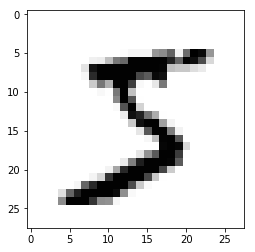

In [11]:
imshow(x_train[0],cmap='Greys')

In [12]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])
initial_instace = np.random.permutation(x_train)[:1]
initial_instace.shape

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


(1, 28, 28, 1)

In [13]:
#from keras import backend as K
#from keras.utils import to_categorical
#from keras.models import Model
#from keras.layers import Dense, Reshape, Flatten, Input, Dropout
#from keras.layers.core import Activation
#from keras.layers.convolutional import Conv2D
#from keras.layers.normalization import BatchNormalization
#from keras.optimizers import Adam, RMSprop, SGD
#from keras.layers.pooling import GlobalAveragePooling2D,MaxPooling2D
#from keras.losses import categorical_crossentropy

input = tf.keras.Input(shape=(28,28,1),name='input_part')
out=tf.keras.layers.Conv2D(32, (5, 5), activation='relu')(input)
out=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(out)
out=tf.keras.layers.Dropout(0.2)(out)
out=tf.keras.layers.Flatten()(out)
out=tf.keras.layers.Dense(128, activation='relu')(out)
out=tf.keras.layers.Dense(10,activation='softmax')(out)

model = tf.keras.Model(input, out)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0402 16:43:51.024849 140735836812160 deprecation.py:506] From /Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
model.fit(x_train,tf.keras.utils.to_categorical(y_train),epochs=2)

Epoch 1/2
60000/60000 [==============================] - 15s 249us/sample - loss: 0.1517 - acc: 0.9548
Epoch 2/2
60000/60000 [==============================] - 17s 276us/sample - loss: 0.0547 - acc: 0.9835


# Minimization

In [15]:
for layer in model.layers:
    layer.trainable=False
    print(layer.trainable)

False
False
False
False
False
False
False


In [16]:
_lam=1
pred_class=0
target_probability=0.5

In [17]:
model.predict(initial_instace)

array([[1.0821414e-07, 4.2472368e-07, 5.2352925e-07, 2.7912642e-05,
        4.9559949e-05, 3.6116423e-06, 6.7935951e-10, 5.5396446e-04,
        5.3786043e-05, 9.9931002e-01]], dtype=float32)

In [18]:
def my_fun(x):
    return 0.9

In [26]:
vector_shape = initial_instace.shape[1:]

for layer in model.layers:
    layer.trainable=False
    
with tf.Session() as sess:     

    pl_class = tf.placeholder(dtype=tf.int32,name='class')
    pl_target_prob = tf.placeholder(dtype=tf.float32, name='target_prob')
    pl_lam = tf.placeholder(dtype=tf.float32, name='lam_param')
    pl_pred = tf.placeholder(dtype=tf.float32, name='cf_prob')
    out_2 = tf.placeholder(dtype=tf.float32, name='preds')

    x=tf.Variable(dtype=tf.float32,initial_value=initial_instace,name='cf')
    
    out_2 = tf.py_func(model.predict,[x],(tf.float32))[0]
    #pl_out = tf.placeholder()
    
    gradient_x = (tf.py_func(model.predict,[x+1e-10],(tf.float32))[0] - tf.py_func(model.predict,[x-1e-10],(tf.float32))[0]) / (2*1e-10)
    
    loss_0 = tf.multiply(pl_lam,(tf.square(out_2[:,pl_class] - pl_target_prob)))

    opt = tf.train.AdamOptimizer()
    gradients=[]
    gradients.append((gradient_x,x))
    print(gradients)
    opt_op = opt.apply_gradients(gradients)
    #opt_op=opt.minimize(loss_0)
    tf.global_variables_initializer().run()
    
    #print(x.get_variable())
    feed_dict = {pl_class:pred_class,pl_target_prob:target_probability,pl_lam:_lam}
    #print(sess.run(out_2,feed_dict))
    for i in range(1000):
        sess.run([opt_op],feed_dict)
    print(sess.run(out_2,feed_dict))


[(<tf.Tensor 'truediv_7:0' shape=<unknown> dtype=float32>, <tf.Variable 'cf_7:0' shape=(1, 28, 28, 1) dtype=float32_ref>)]


UnknownError: RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().
Traceback (most recent call last):

  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 207, in __call__
    ret = func(*args)

  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1167, in predict
    callbacks=callbacks)

  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_arrays.py", line 239, in model_iteration
    model.reset_metrics()

  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1173, in reset_metrics
    m.reset_states()

  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py", line 200, in reset_states
    K.batch_set_value([(v, 0) for v in self.variables])

  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py", line 2919, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)

  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 932, in run
    run_metadata_ptr)

  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1080, in _run
    raise RuntimeError('The Session graph is empty.  Add operations to the '

RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().


	 [[node PyFunc_22 (defined at <ipython-input-26-fe94593fe82c>:19) ]]

Original stack trace for 'PyFunc_22':
  File "/Users/Gigio/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Gigio/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Users/Gigio/anaconda3/lib/python3.7/asyncio/base_events.py", line 528, in run_forever
    self._run_once()
  File "/Users/Gigio/anaconda3/lib/python3.7/asyncio/base_events.py", line 1764, in _run_once
    handle._run()
  File "/Users/Gigio/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-fe94593fe82c>", line 19, in <module>
    gradient_x = (tf.py_func(model.predict,[x+1e-10],(tf.float32))[0] - tf.py_func(model.predict,[x-1e-10],(tf.float32))[0]) / (2*1e-10)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 476, in py_func
    return py_func_common(func, inp, Tout, stateful, name=name)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 458, in py_func_common
    func=func, inp=inp, Tout=Tout, stateful=stateful, eager=False, name=name)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 282, in _internal_py_func
    input=inp, token=token, Tout=Tout, name=name)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_script_ops.py", line 159, in py_func
    "PyFunc", input=input, token=token, Tout=Tout, name=name)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3537, in create_op
    op_def=op_def)
  File "/Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1961, in __init__
    self._traceback = tf_stack.extract_stack()


In [47]:
clf.predict_proba(X)

array([[0.97672869, 0.01241837, 0.01085294]])

In [34]:
from scipy.spatial.distance import cityblock
def _metric_distance(x0,x1):
    return cityblock(x0,x1)
    

In [49]:
def _countefactual_loss(x, XX=X.flatten(), pc=pred_class):
    pred_tmp = clf.predict_proba(x.reshape(X.shape))[:, pc]
    loss_0 = 0.5*(pred_tmp - 1.0)**2
    loss_1 = (0.5)*_metric_distance(x, XX)
    print(loss_0,loss_1)
    return loss_0#+loss_1

In [52]:
res = minimize(_countefactual_loss, X, method=None,options={'maxiter': 1000})

[0.00027078] 0.0
[0.00027078] 7.450580596923828e-09
[0.00027078] 7.450580596923828e-09
[0.00027078] 7.450580596923828e-09
[0.00027078] 7.450580596923828e-09
[0.00027078] 0.0
[0.0002704] 0.0005727034804294817
[0.0002704] 0.0005727034804294817
[0.0002704] 0.0005727109310100786
[0.0002704] 0.0005727109310100786
[0.0002704] 0.0005726960298488848
[0.0002704] 0.0005726960298488848
[0.00026892] 0.0028635174021474086
[0.00026892] 0.0028635174021474086
[0.00026892] 0.0028635248527280055
[0.00026892] 0.0028635248527280055
[0.00026892] 0.0028635099515668117
[0.00026892] 0.0028635099515668117
[0.00026313] 0.012026773089019116
[0.00026313] 0.012026773089019116
[0.00026313] 0.012026780539599713
[0.00026313] 0.012026780539599713
[0.00026313] 0.012026765638438519
[0.00026313] 0.012026765638438519
[0.00024209] 0.048679795836505946
[0.00024209] 0.048679795836505946
[0.00024209] 0.04867980328708654
[0.00024209] 0.04867980328708654
[0.00024209] 0.04867978838592535
[0.00024209] 0.04867978838592535
[0.00019

In [51]:
clf.predict_proba(res.x.reshape(1,-1))

array([[0.98415889, 0.00709285, 0.00874826]])